Importing libraries

In [61]:
import pandas as pd
import numpy as np
import json
import nltk
import seaborn as sns
import re
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm

Extract data from file keeping only 4 columns

In [62]:
data = []

with open("Data/booksummaries/booksummaries.txt", encoding="utf8") as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        data.append(row)

book_id = []
book_name = []
summary = []
genre = []

for i in tqdm(data):
    book_id.append(i[0])
    book_name.append(i[2])
    genre.append(i[5])
    summary.append(i[6])

books = pd.DataFrame({'book_id': book_id, 'book_name': book_name,
                       'genre': genre, 'summary': summary})

books.head(2)

16559it [00:00, 25203.35it/s]
100%|██████████| 16559/16559 [00:00<00:00, 1412488.66it/s]


,book_id,book_name,genre,summary
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."


In [63]:
# json genres example
json.loads(books['genre'][1]).values()

print(f'Dataset size before cleaning: {len(books)}')

# drop data where genre is empty
books.drop(books[books['genre']==''].index, inplace=True)

# drop data where summary is empty
books.drop(books[books['summary']==''].index, inplace=True)

print(f'Dataset size after cleaning: {len(books)}')

Dataset size before cleaning: 16559
Dataset size after cleaning: 12841


Decode JSON format in 'genre' column to 'new_genre' column\
Create a dictionary with all genres as keys and their number of occurrence as values

In [64]:
genres = []
for i in books['genre']:
    x = list(json.loads(i).values())
    genres.append(x)
books['genre_new'] = genres

genres_sum = sum(genres,[])
all_genres = {}

for g in set(genres_sum):
    all_genres[g] = genres_sum.count(g)

all_genres = dict(sorted(all_genres.items(), key=lambda x: x[1]))


Different genres count: 227
Top 50 popular genres:


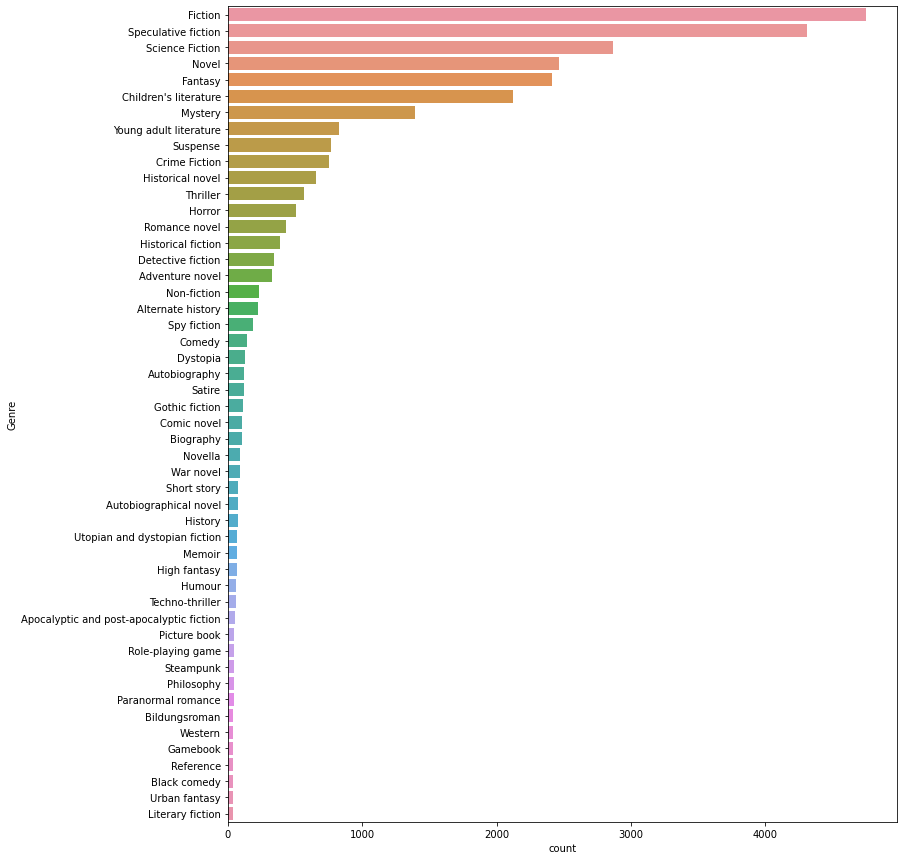

In [65]:
print(f'Different genres count: {len(all_genres)}')
print('Top 50 popular genres:')
vis = pd.DataFrame({'genre':list(all_genres.keys()), 'count':list(all_genres.values())}) 

# visualize genres and frequencies
dat = vis.nlargest(columns="count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=dat, x= "count", y = "genre") 
ax.set(ylabel = 'Genre') 
plt.show()

In [66]:
remove_genres = list({key: value for key, value in all_genres.items() if value <= 500})
remove_genres.append("Fiction")
all_genres = {key: value for key, value in all_genres.items() if value > 500}
all_genres.pop('Fiction')

print(f'Remove genres number: {len(remove_genres)}')
print(f'All genres number: {len(all_genres)}')
print(all_genres)

Remove genres number: 215
All genres number: 12
{'Horror': 511, 'Thriller': 568, 'Historical novel': 654, 'Crime Fiction': 753, 'Suspense': 765, 'Young adult literature': 825, 'Mystery': 1396, "Children's literature": 2122, 'Fantasy': 2413, 'Novel': 2463, 'Science Fiction': 2870, 'Speculative fiction': 4314}


In [67]:
# remove genres from dataset
for rem in remove_genres:
    i = 0
    for g in books['genre_new']:
        i += 1
        if rem in g: 
            g.remove(rem)

id_empty=[]
for id in books['book_id']:
    if books[books['book_id']==id]['genre_new'].tolist()[0] == []: 
        id_empty.append(id)

print(len(id_empty))

2028


In [68]:
# drop data where genre is empty
for id in id_empty:
    books.drop(books[books['book_id']==id].index, inplace=True)

genres = []
for i in books['genre_new']:
    x = list(i)[0]
    genres.append(x)
books['genre'] = genres

# After remove genres
print(len(books))

books.head(2)

10813


,book_id,book_name,genre,summary,genre_new
0,620,Animal Farm,Children's literature,"Old Major, the old boar on the Manor Farm, ca...","[Children's literature, Speculative fiction]"
1,843,A Clockwork Orange,Science Fiction,"Alex, a teenager living in near-future Englan...","[Science Fiction, Speculative fiction]"


Preprocessing text functions:
- to lowercase
- remove everething except letters
- remove whitespaces 
- remove stop words
- text stemming (Porter)\
<img src="https://user.oc-static.com/upload/2020/10/22/16033551309054_stemming%20example.png" alt="drawing" width="300"/>

In [69]:
def preprocess(text):
    text = re.sub("\'", "", str(text)) 
    text = re.sub("[^a-zA-Z]", " ", str(text)) 
    text = ' '.join(text.split()) 
    text = text.lower() 

    return text

books['clear_summary'] = books['summary'].apply(lambda x: preprocess(x))

In [70]:
# Removing stop words ("a", "an"...)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

books['clear_summary'] = books['clear_summary'].apply(lambda x: remove_stopwords(x))

In [71]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stemming(text):
    stemText = ""
    for word in text.split():
        stem = stemmer.stem(word)
        stemText += stem
        stemText += " "
    stemText = stemText.strip()
    return stemText

books['clear_summary'] = books['clear_summary'].apply(lambda x: stemming(x))

In [72]:
# After summary preprocessing
books.head(2)

print(books['clear_summary'])

0        old major old boar manor farm call anim farm m...
1        alex teenag live near futur england lead gang ...
2        text plagu divid five part town oran thousand ...
4        novel posit space around milki way divid conce...
6        ged young boy gont one larger island north arc...
                               ...                        
16546    novel anni stonewal daughter heaven casteel ta...
16549    stori start former govern agent frank compton ...
16551    seri follow charact nick stone ex militari man...
16555    reader first meet rapp covert oper iran discov...
16558    makar devushkin varvara dobroselova second cou...
Name: clear_summary, Length: 10813, dtype: object


Word frequency visualization

50 most frequent words:


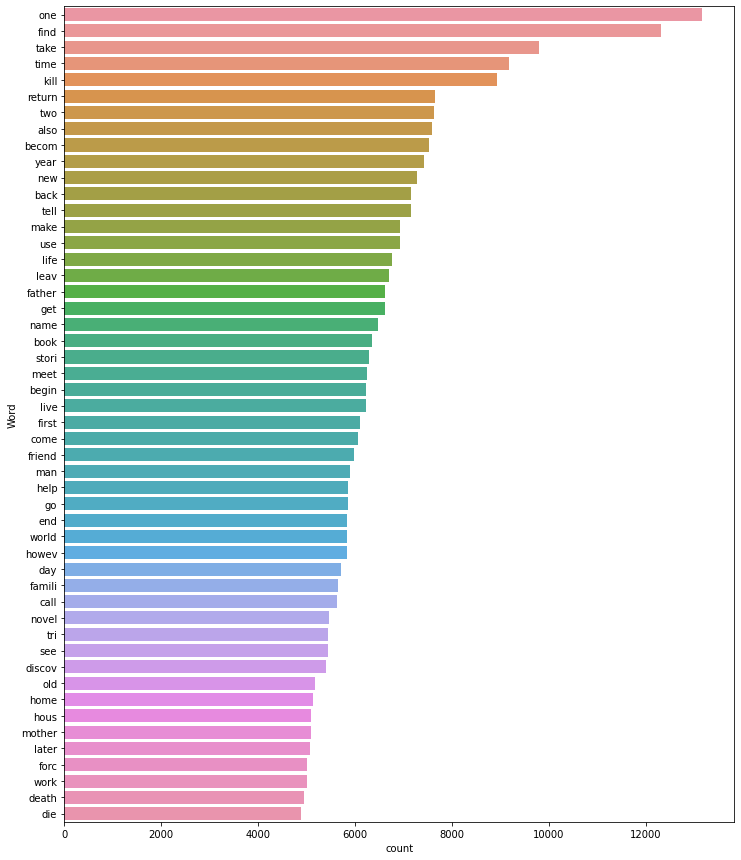

In [73]:
def frequency(text, numb):
    allwords = ' '.join([x for x in text]) 
    allwords = allwords.split() 
    dist = nltk.FreqDist(allwords) 
    wordsdf = pd.DataFrame({'word':list(dist.keys()), 'count':list(dist.values())}) 

    d = wordsdf.nlargest(columns="count", n = numb) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

print('50 most frequent words:')
frequency(books['clear_summary'], 50)